In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler


def combine_data():
    # Directory containing participant CSV files
    data_dir = 'downsampled_data'

    # Initialize an empty list to store dataframes
    all_data = []

    # Loop through each participant's file
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            # Load the CSV file
            participant_data = pd.read_csv("downsampled_data/"+filename)
            
            # Append to the list
            all_data.append(participant_data)

    # Combine all data into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)
    return combined_data


In [ ]:
# Check the combined data
# print(combined_data)
combined_data = combine_data()
#remove rows hwere lseep stage is N3 and Missing
combined_data = combined_data[combined_data['sleep_stage'] != 'N3']

#drop window times
combined_data = combined_data.drop(columns=["window_start_time", "window_end_time"])

# Encode sleep stage labels
label_mapping = {
    'W': 0,
    'N1': 1,
    'N2': 2,
    # 'N3': 3,
    'R': 3
}
num_classes = len(label_mapping)
combined_data['sleep_stage'] = combined_data['sleep_stage'].map(label_mapping)


features = combined_data.drop(columns=['sleep_stage'])
scaled_features = features.drop(columns=['participant_id'])
print(features.shape)
print(features.columns)

scaler = StandardScaler()
# scaled without participant id
scaled_features[scaled_features.columns] = scaler.fit_transform(scaled_features[scaled_features.columns])
scaled_features['participant_id'] = features['participant_id'] # add p_id back
num_features = features.shape[1] # includes participant_id

# Combine scaled features and labels
data_processed = np.hstack((scaled_features, combined_data[['sleep_stage']].values))


sleep_stage
N2         32976
W          16095
N1          7375
R           7028
Missing       35
Name: count, dtype: int64
(63509, 28)
Index(['participant_id', 'BVP_mean', 'BVP_std', 'BVP_min', 'BVP_max',
       'BVP_range', 'BVP_median', 'SDNN', 'median_nni', 'IBI_mean', 'x_std',
       'y_std', 'z_std', 'mag_mean', 'mag_std', 'mag_max', 'movement_density',
       'burst_count', 'EDA_mean', 'EDA_std', 'EDA_trend', 'TEMP_mean',
       'TEMP_std', 'TEMP_slope', 'HR_mean', 'HR_std', 'HR_range', 'HR_trend'],
      dtype='object')


In [3]:
class_dis = combined_data['sleep_stage'].value_counts()
print(class_dis)

sleep_stage
2.0    32976
0.0    16095
1.0     7375
3.0     7028
Name: count, dtype: int64


In [18]:
from scipy.stats import mode
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        
        # Extract the labels for the sequence
        sequence_labels = data[i:i+sequence_length, -1]  # Labels: sleep stage)
        if np.isnan(sequence_labels).any(): # skip nan labels
            continue
        
        X.append(data[i:i+sequence_length, :-1])  # Features (except the last which is sleep_stage)
        
        
        # Calculate the mode label (most frequent label in the sequence)
        # mode_label = mode(sequence_labels).mode  # Use scipy.stats.mode
        y.append(data[i:i+sequence_length, -1][-1])
        # print(data[i:i+sequence_length, -1])
    # print(np.array(X).shape, np.array(y).shape)
    return np.array(X), np.array(y)

sequence_length = 30  # 10 epochs = 5 minutes
# X, y = create_sequences(data_processed, sequence_length)

In [19]:
def process_df(df):
    df = df.drop(columns=['participant_id'])
    df_features = df.drop(columns=['sleep_stage'])
    data_proc = np.hstack((df_features, df[['sleep_stage']].values))
    return data_proc

In [20]:
from sklearn.model_selection import train_test_split

p_ids = np.unique(combined_data["participant_id"].values)

# Split by participant ID
train_ids, test_ids = train_test_split(np.unique(p_ids), test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42)  # 60% train, 20% val, 20% test

# Create splits
train_data = combined_data[combined_data['participant_id'].isin(train_ids)]
val_data = combined_data[combined_data['participant_id'].isin(val_ids)]
test_data = combined_data[combined_data['participant_id'].isin(test_ids)]

data_processed_tr = process_df(train_data)
# print(data_processed_tr.shape)
data_processed_val = process_df(val_data)
# print(data_processed_val.shape)
data_processed_test = process_df(test_data)
# print(data_processed_test.shape)

# Create sequences for each split
X_train, y_train = create_sequences(data_processed_tr, sequence_length)
# print(X_train.shape, y_train.shape)
X_val, y_val = create_sequences(data_processed_val, sequence_length)
# print(X_val.shape, y_val.shape)
X_test, y_test = create_sequences(data_processed_test, sequence_length)
# print(X_test.shape, y_test.shape)


In [21]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
y_train_flat = y_train.ravel()
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_flat), y=y_train_flat)
class_weights = dict(enumerate(class_weights))

# Model 3 (7-layer)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

model = Sequential()
model.add(Input(shape=(sequence_length, num_features-1)))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
    ]
)

model.save("lstm_7layer.keras")

Epoch 1/100
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 49s 38ms/step - accuracy: 0.3418 - loss: 1.3615 - val_accuracy: 0.3097 - val_loss: 1.3732 - learning_rate: 1.0000e-04
Epoch 2/100
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 44s 38ms/step - accuracy: 0.3691 - loss: 1.2894 - val_accuracy: 0.2888 - val_loss: 1.3990 - learning_rate: 1.0000e-04
Epoch 3/100
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.3659 - loss: 1.2649 - val_accuracy: 0.2819 - val_loss: 1.4214 - learning_rate: 1.0000e-04
Epoch 4/100
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.3698 - loss: 1.2414 - val_accuracy: 0.2957 - val_loss: 1.4188 - learning_rate: 1.0000e-04
Epoch 5/100
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 49s 42ms/step - accuracy: 0.4026 - loss: 1.2137 - val_accuracy: 0.2652 - val_loss: 1.4822 - learning_rate: 1.0000e-04
Epoch 6/100
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4072 - loss: 1.2022 - val_accuracy: 0.3024 - val_loss: 1.4251 - learning_rate: 1.0000e-04
Epoch 7/100
1154/1154 ━━━━━━━━━━━━

## Model 2 (5 layer)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    class_weight=class_weights,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

model.save("lstm_5layer.keras")

Epoch 1/10
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.3570 - loss: 1.3150 - val_accuracy: 0.2282 - val_loss: 1.3648
Epoch 2/10
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.3189 - loss: 1.2688 - val_accuracy: 0.3195 - val_loss: 1.2813
Epoch 3/10
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.3260 - loss: 1.2325 - val_accuracy: 0.2908 - val_loss: 1.3670
Epoch 4/10
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.3388 - loss: 1.2295 - val_accuracy: 0.2887 - val_loss: 1.3032
Epoch 5/10
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.3464 - loss: 1.2226 - val_accuracy: 0.4012 - val_loss: 1.2949
Epoch 6/10
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.3880 - loss: 1.2092 - val_accuracy: 0.3126 - val_loss: 1.3314
Epoch 7/10
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.3579 - loss: 1.2210 - val_accuracy: 0.3399 - val_loss: 1.2925
Epoch 8/10
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - accuracy: 0.3879 -

# Model 1 (3-layer)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(Input(shape=(sequence_length, num_features-1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64)

model.save('lstm_3layer.keras')

Epoch 1/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5317 - loss: 1.1767
Epoch 2/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5811 - loss: 1.0938
Epoch 3/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5867 - loss: 1.0720
Epoch 4/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5879 - loss: 1.0768
Epoch 5/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5932 - loss: 1.0615
Epoch 6/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5903 - loss: 1.0674
Epoch 7/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5896 - loss: 1.0652
Epoch 8/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5925 - loss: 1.0648
Epoch 9/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5875 - loss: 1.0734
Epoch 10/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5939 - loss: 1.0655


# Model Evaluation

Run one of the models above and then run this evaluation

409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4108 - loss: 1.2780
Test Accuracy: 38.93%
409/409 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
              precision    recall  f1-score   support

         0.0       0.49      0.69      0.58      3724
         1.0       0.12      0.07      0.09      1241
         2.0       0.67      0.28      0.39      6783
         3.0       0.13      0.42      0.19      1313

    accuracy                           0.39     13061
   macro avg       0.35      0.36      0.31     13061
weighted avg       0.51      0.39      0.40     13061



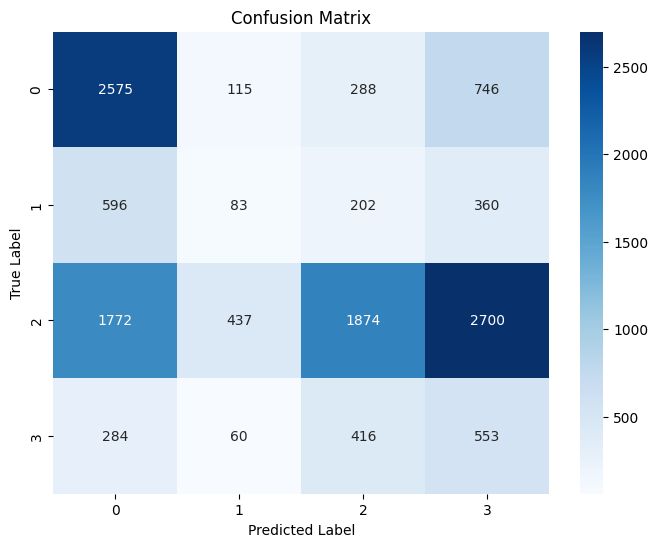

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_classes)
print(report)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
